In [1]:
!pip install -q yfinance pandas matplotlib

In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math

In [50]:
# Load SPY historical data from Yahoo Finance
def get_data(start_date, end_date):
    data = yf.download("SPY", start=start_date, end=end_date)
    return data

In [52]:
# Calculate Weighted Moving Average
def weighted_moving_average(data, date, period):
    index = data.index.get_loc(date)
    window = data['Close'].iloc[index-period-1:index+1]
    denom = period * (period+1) / 2
    wma = 0
    weights = range(1, period+1)
    for i in range(period):
        wma += window.iloc[i] * weights[i] / denom
    return wma

In [54]:
def standard_deviation(data, date, period, wma):
    index = data.index.get_loc(date)
    window = data['Close'].iloc[index-period-1:index+1]
    deviations = []
    for i in range(period):
        deviations.append((window.iloc[i] - wma) ** 2)
    variance = 0
    for dev in deviations:
       variance += dev
    variance /= 20
    stdDev = math.sqrt(variance)
    return stdDev

In [56]:
# Simulate mean reversion strategy
def backtest_strategy(data):
    # Initialize starting values
    initial_cash = 10000  # Starting with $10,000
    cash = initial_cash
    shares = 0
    trade_log = []
    
    for date in data.index:
        if 20 < data.index.get_loc(date):
            wma = weighted_moving_average(data, date, 20)
            stdDev = standard_deviation(data, date, 20, wma)
            price = data.loc[date, 'Close']
            zScore = (price-wma)/stdDev

            if zScore >= 1.5 and shares > 0:
                cash += 10 * price
                shares -= 10
                trade_log.append((date, 'SELL', 10, price, cash, shares))

            if zScore <= 1.5 and shares == 0:
                shares += 10
                cash -= 10 * price
                trade_log.append((date, 'BUY', 10, price, cash, shares))

    # Store trade log in DataFrame
    trade_df = pd.DataFrame(trade_log, columns=['Date', 'Action', 'Shares', 'Price', 'Cash', 'Total Shares'])
    trade_df.set_index('Date', inplace=True)

    # Final portfolio value
    final_portfolio_value = cash + shares * data.iloc[-1]['Close']
    
    # Calculate total P/L
    total_pl = final_portfolio_value - initial_cash
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Profit/Loss: ${total_pl:.2f}")
    
    return trade_df, final_portfolio_value

In [58]:
# Plot the price of SPY and mark trades on the chart
def plot_trades(data, trade_df):
    plt.figure(figsize=(10,6))
    plt.plot(data['Close'], label='SPY Price')
    
    buy_signals = trade_df[trade_df['Action'] == 'BUY']
    sell_signals = trade_df[trade_df['Action'] == 'SELL']

    plt.scatter(buy_signals.index, buy_signals['Price'], marker='^', color='g', label='Buy Signal', s=100)
    plt.scatter(sell_signals.index, sell_signals['Price'], marker='v', color='r', label='Sell Signal', s=100)
    
    plt.title('SPY Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [60]:
start_date = '2021-01-01'
end_date = '2022-01-01'

# Run the backtest
data = get_data(start_date, end_date)

trade_df, final_value = backtest_strategy(data)

# Show the trade log
print(trade_df)

[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: $10738.70
Total Profit/Loss: $738.70
           Action  Shares       Price          Cash  Total Shares
Date                                                             
2021-02-03    BUY      10  381.850006   6181.499939            10
2021-02-04   SELL      10  386.190002  10043.399963             0
2021-02-16    BUY      10  392.299988   6120.400085            10
2021-03-11   SELL      10  393.529999  10055.700073             0
2021-03-18    BUY      10  391.480011   6140.899963            10
2021-04-05   SELL      10  406.359985  10204.499817             0
2021-04-14    BUY      10  411.450012   6089.999695            10
2021-05-07   SELL      10  422.119995  10311.199646             0
2021-05-10    BUY      10  417.940002   6131.799622            10
2021-06-25   SELL      10  426.609985  10397.899475             0
2021-07-08    BUY      10  430.920013   6088.699341            10
2021-07-09   SELL      10  435.519989  10443.899231             0
2021-07-13    BU

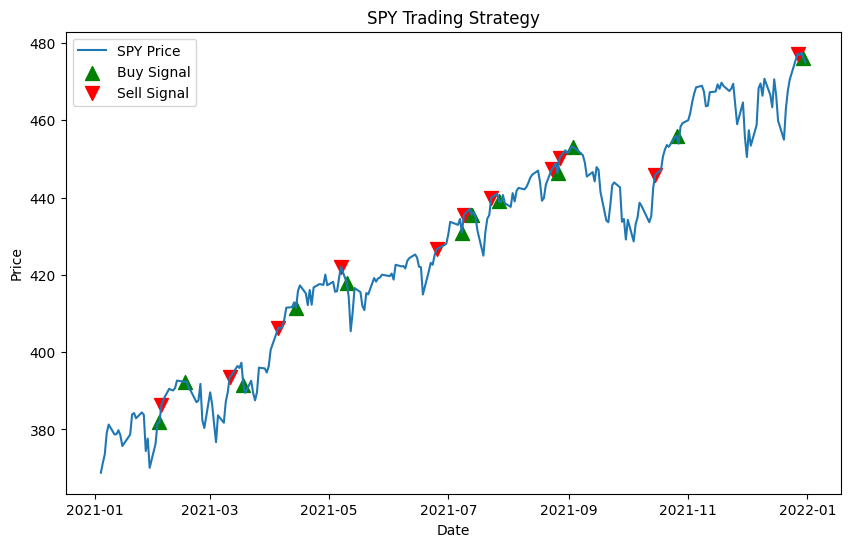

In [62]:
# Plot the trades
plot_trades(data, trade_df)